In [1]:
import numpy as np
import torch
import torchvision.transforms as transforms
import torch.nn.functional as F
from wilds import get_dataset
from wilds.common.data_loaders import get_train_loader, get_eval_loader
from wilds.common.grouper import CombinatorialGrouper
from wilds.datasets.wilds_dataset import WILDSSubset

from models import DeepDANN
from mixup import mixup_criterion
import options
import random

from main import get_wilds_dataset, get_split, get_eval_loader, build_model
from main import NUM_CLASSES, DEFAULT_TRANSFORM, NUM_DOMAINS, METADATA_KEYS

import sklearn
from sklearn.manifold import TSNE 

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline

import seaborn as sns
from sklearn.decomposition import PCA
import pandas as pd

cam_mix = 'weights/camelyon-mixup.pth'
cam_nomix = 'weights/camelyon-nomixup_final_2021-05-26T17:56:21.262615.pth'
iwild_mix = 'weights/iwildcam-mixup-3epoch_final_2021-05-25T18:25:23.230189.pth'
iwild_nomix = 'weights/from-ep2-iwildcam-mixup-3epoch_final_2021-05-26T05:52:54.712932.pth'

In [2]:
def scatter_plot(d_train, Y_train, d_val, Y_val, d_test, Y_test, img_name):
    fig, ax = plt.subplots()
    train_fig = sns.scatterplot(x=d_train[:,0], y=d_train[:,1],hue=Y_train,palette=sns.color_palette("Blues",np.unique(Y_train).shape[0]),alpha=0.7,ax=ax)
    val_fig = sns.scatterplot(x=d_val[:,0], y=d_val[:,1],hue=Y_val,palette=sns.color_palette("Greens",np.unique(Y_val).shape[0]),alpha=0.7,ax=ax)
    test_fig = sns.scatterplot(x=d_test[:,0], y=d_test[:,1],hue=Y_test,palette=sns.color_palette("Oranges",np.unique(Y_test).shape[0]),alpha=0.7,ax=ax)


    train_fig.tick_params(bottom=False, left=False)
    train_fig.set(xticklabels=[])
    train_fig.set(yticklabels=[])
    train_norm = plt.Normalize(Y_train.min(), Y_train.max())
    train_sm = plt.cm.ScalarMappable(cmap="Blues", norm=train_norm)
    train_sm.set_array([])
    train_cax = fig.add_axes([0.25, 0.1, 0.15, 0.01])
    ax.figure.colorbar(train_sm,label="Train", ticks=[], cax=train_cax, orientation = 'horizontal')


    val_fig.tick_params(bottom=False, left=False)
    val_fig.set(xticklabels=[])
    val_fig.set(yticklabels=[])
    val_norm = plt.Normalize(Y_val.min(), Y_val.max())
    val_sm = plt.cm.ScalarMappable(cmap="Greens", norm=val_norm)
    val_sm.set_array([])
    val_cax = fig.add_axes([0.45, 0.1, 0.15, 0.01])
    ax.figure.colorbar(val_sm, label="Val", ticks=[], cax=val_cax, orientation='horizontal')

    test_fig.tick_params(bottom=False, left=False)
    test_fig.set(xticklabels=[])
    test_fig.set(yticklabels=[])
    test_norm = plt.Normalize(Y_test.min(), Y_test.max())
    test_sm = plt.cm.ScalarMappable(cmap="Oranges", norm=test_norm)
    test_sm.set_array([])
    test_cax = fig.add_axes([0.65, 0.1, 0.15, 0.01])
    ax.figure.colorbar(test_sm,label="Test", ticks=[], cax=test_cax, orientation='horizontal')


    fig.set_size_inches([6,5],forward=True)
    ax.get_legend().remove()
    sns.despine(bottom = True, left = True, right=True,ax=ax)

    fig.savefig(img_name)

In [3]:
dataset = get_wilds_dataset('iwildcam', '../WILDS')
train_data = get_split(dataset, 'train', transforms=DEFAULT_TRANSFORM['iwildcam'])
test_data = get_split(dataset, 'test', transforms=DEFAULT_TRANSFORM['iwildcam'])
val_data = get_split(dataset, 'val', transforms=DEFAULT_TRANSFORM['iwildcam'])
grouper = CombinatorialGrouper(dataset, [METADATA_KEYS['iwildcam']])
train_loader = get_train_loader('group', train_data, batch_size=20, uniform_over_groups=True, grouper=grouper, distinct_groups=True, n_groups_per_batch=1)
val_loader = get_train_loader('group', val_data, batch_size=20, uniform_over_groups=True, grouper=grouper, distinct_groups=True, n_groups_per_batch=1)
test_loader = get_train_loader('group', test_data, batch_size=20, uniform_over_groups=True, grouper=grouper, distinct_groups=True, n_groups_per_batch=1)

[INFO] 2021-06-02 19:25:56,456 main.py:52 - Loaded dataset iwildcam with 203029 examples



# Run Non Mix Up Experiments Below

In [4]:
# no mix up
model = build_model('resnet50', NUM_CLASSES['iwildcam'], NUM_DOMAINS['iwildcam'], 1, -1)
model.load_state_dict(torch.load(iwild_nomix))
for p in model.parameters():
        p.requires_grad = False
model.eval()
extractor = model.feature_extractor

In [5]:
# no mix up
i = 0
val_features, val_ids = [], []
test_features, test_ids = [], []
train_features, train_ids = [], []

# val data
for x, y_true, metadata in val_loader:
    # x: batch_size*3*448*448
    # y_true: batch_size
    # y_pred: batch_size * 2048
    groupids = grouper.metadata_to_group(metadata)
    y_pred = extractor(x.to('cuda'))
    val_features.append(y_pred.cpu().numpy())
    val_ids.append(groupids.cpu().numpy())
    i += 1
    if i == 5:
        break
val_features = np.array(val_features).reshape(-1, 2048)
val_ids = np.array(val_ids).reshape(-1)
print(val_features.shape, val_ids.shape)
val_id = np.unique(val_ids)
print("val id: ", val_id)

# test data
for x, y_true, metadata in test_loader:
    # x: batch_size*3*448*448
    # y_true: batch_size
    # y_pred: batch_size * 2048
    groupids = grouper.metadata_to_group(metadata)
    y_pred = extractor(x.to('cuda'))
    test_features.append(y_pred.cpu().numpy())
    test_ids.append(groupids.cpu().numpy())
    i += 1
    if i == 13:
        break
test_features = np.array(test_features).reshape(-1, 2048)
test_ids = np.array(test_ids).reshape(-1)
print(test_features.shape, test_ids.shape)
test_id = np.unique(test_ids)
print("test id: ", test_id)

# train data
for x, y_true, metadata in train_loader:
    # x: batch_size*3*448*448
    # y_true: batch_size
    # y_pred: batch_size * 2048
    groupids = grouper.metadata_to_group(metadata)
    y_pred = extractor(x.to('cuda'))
    train_features.append(y_pred.cpu().numpy())
    train_ids.append(groupids.cpu().numpy())
    i += 1
    if i == 50:
        break
train_features = np.array(train_features).reshape(-1, 2048)
train_ids = np.array(train_ids).reshape(-1)
print(train_features.shape, train_ids.shape)
train_id = np.unique(train_ids)
print("val id: ", train_id)

print(i)

(100, 2048) (100,)
val id:  [ 27  79 114 154]
(160, 2048) (160,)
test id:  [ 29  78 120 169 176 288 301]
(740, 2048) (740,)
val id:  [ 14  16  39  52  54  55  65  84  97  99 102 106 118 138 180 197 201 202
 209 216 220 229 246 248 250 254 257 292 294 295 296 305 308 319 322]
50


In [10]:
# no mix up

X_train = np.vstack([train_features[train_ids==i] for i in train_id])
Y_train = np.hstack([train_ids[train_ids==i] for i in train_id])
print("train:",np.array(X_train).shape, np.array(Y_train).shape)

X_val = np.vstack([val_features[val_ids==i] for i in val_id])
Y_val = np.hstack([val_ids[val_ids==i] for i in val_id])
print("val:",np.array(X_val).shape, np.array(Y_val).shape)

X_test = np.vstack([test_features[test_ids==i] for i in test_id])
Y_test = np.hstack([test_ids[test_ids==i] for i in test_id])
print("test:",np.array(X_test).shape, np.array(Y_test).shape)

X = np.concatenate((X_train, X_val, X_test))
Y = np.concatenate((Y_train, Y_val, Y_test))
ID_sort = np.hstack((train_id, val_id, test_id))
ID_sort = np.sort(ID_sort)
print(X.shape, Y.shape, ID_sort.shape)


pca = PCA(n_components=400)
pca.fit(X)
print(pca.singular_values_)


train: (740, 2048) (740,)
val: (100, 2048) (100,)
test: (160, 2048) (160,)
(1000, 2048) (1000,) (46,)
[220.48979   187.10677   157.15683   140.75056   122.634346  113.30036
 100.55111   100.34603    93.20101    91.42879    86.084694   81.36494
  75.51024    73.29782    71.28696    66.70854    64.0561     60.00595
  58.33235    54.327316   52.59814    50.93368    47.9719     47.06592
  44.673115   42.158733   38.94528    37.89212    36.948917   36.50223
  34.937325   33.01398    31.601805   30.513887   29.399864   28.859777
  27.235233   26.785002   26.023018   25.75898    24.941357   24.439095
  23.37118    23.012152   22.4194     22.176294   20.926226   20.550253
  20.471266   19.430746   18.498743   17.866428   17.39197    17.313002
  17.156631   17.142763   16.739471   16.590897   16.14115    15.907795
  15.532709   15.137589   14.703873   14.668044   14.418539   14.031414
  13.919203   13.863018   13.545061   13.363494   13.112527   12.942782
  12.750692   12.64208    12.379334   1

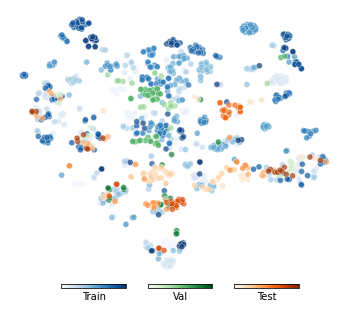

In [15]:
# no mix up
X_PCA = PCA(n_components=400).fit_transform(X)
d_X = TSNE(perplexity=30, n_iter=5000, learning_rate=20).fit_transform(X_PCA)
d_train = d_X[:740]
d_val = d_X[740:840]
d_test = d_X[840:]
scatter_plot(d_train, Y_train, d_val, Y_val, d_test, Y_test, "iwildcam_no_30.png")

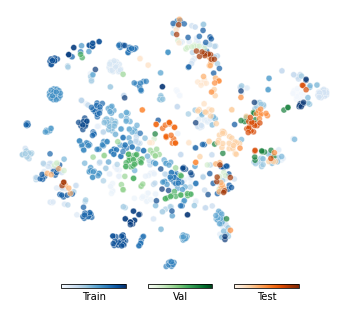

In [16]:
# no mix up
X_PCA = PCA(n_components=400).fit_transform(X)
d_X = TSNE(perplexity=50, n_iter=5000, learning_rate=20).fit_transform(X_PCA)
d_train = d_X[:740]
d_val = d_X[740:840]
d_test = d_X[840:]

scatter_plot(d_train, Y_train, d_val, Y_val, d_test, Y_test, "iwildcam_no_50.png")

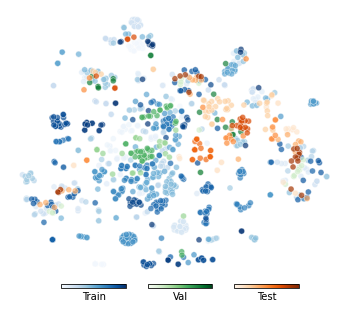

In [17]:
# no mix up
X_PCA = PCA(n_components=400).fit_transform(X)
d_X = TSNE(perplexity=80, n_iter=5000, learning_rate=20).fit_transform(X_PCA)
d_train = d_X[:740]
d_val = d_X[740:840]
d_test = d_X[840:]

scatter_plot(d_train, Y_train, d_val, Y_val, d_test, Y_test, "iwildcam_no_80.png")


# Run Mix Up Experiments Below

In [18]:
# mix up
model = build_model('resnet50', NUM_CLASSES['iwildcam'], NUM_DOMAINS['iwildcam'], 1, 1)
model.load_state_dict(torch.load(iwild_mix))
for p in model.parameters():
        p.requires_grad = False
model.eval()
extractor = model.feature_extractor

In [19]:
# mix up
i = 0
val_features, val_ids = [], []
test_features, test_ids = [], []
train_features, train_ids = [], []

# val data
for x, y_true, metadata in val_loader:
    # x: batch_size*3*448*448
    # y_true: batch_size
    # y_pred: batch_size * 2048
    groupids = grouper.metadata_to_group(metadata)
    y_pred = extractor(x.to('cuda'))
    val_features.append(y_pred.cpu().numpy())
    val_ids.append(groupids.cpu().numpy())
    i += 1
    if i == 5:
        break
val_features = np.array(val_features).reshape(-1, 2048)
val_ids = np.array(val_ids).reshape(-1)
print(val_features.shape, val_ids.shape)
val_id = np.unique(val_ids)
print("val id: ", val_id)

# test data
for x, y_true, metadata in test_loader:
    # x: batch_size*3*448*448
    # y_true: batch_size
    # y_pred: batch_size * 2048
    groupids = grouper.metadata_to_group(metadata)
    y_pred = extractor(x.to('cuda'))
    test_features.append(y_pred.cpu().numpy())
    test_ids.append(groupids.cpu().numpy())
    i += 1
    if i == 13:
        break
test_features = np.array(test_features).reshape(-1, 2048)
test_ids = np.array(test_ids).reshape(-1)
print(test_features.shape, test_ids.shape)
test_id = np.unique(test_ids)
print("test id: ", test_id)

# train data
for x, y_true, metadata in train_loader:
    # x: batch_size*3*448*448
    # y_true: batch_size
    # y_pred: batch_size * 2048
    groupids = grouper.metadata_to_group(metadata)
    y_pred = extractor(x.to('cuda'))
    train_features.append(y_pred.cpu().numpy())
    train_ids.append(groupids.cpu().numpy())
    i += 1
    if i == 50:
        break
train_features = np.array(train_features).reshape(-1, 2048)
train_ids = np.array(train_ids).reshape(-1)
print(train_features.shape, train_ids.shape)
train_id = np.unique(train_ids)
print("val id: ", train_id)

print(i)

(100, 2048) (100,)
val id:  [ 57  66  79 143 309]
(160, 2048) (160,)
test id:  [ 21  58  86 120 176 193 280]
(740, 2048) (740,)
val id:  [  8  11  14  23  26  32  44  61  64  70  82  84 100 103 109 129 139 157
 159 160 161 195 197 199 208 222 226 256 277 293 303 312 317 322]
50


In [20]:
# mix up

X_train = np.vstack([train_features[train_ids==i] for i in train_id])
Y_train = np.hstack([train_ids[train_ids==i] for i in train_id])
print("train:",np.array(X_train).shape, np.array(Y_train).shape)

X_val = np.vstack([val_features[val_ids==i] for i in val_id])
Y_val = np.hstack([val_ids[val_ids==i] for i in val_id])
print("val:",np.array(X_val).shape, np.array(Y_val).shape)

X_test = np.vstack([test_features[test_ids==i] for i in test_id])
Y_test = np.hstack([test_ids[test_ids==i] for i in test_id])
print("test:",np.array(X_test).shape, np.array(Y_test).shape)

X = np.concatenate((X_train, X_val, X_test))
Y = np.concatenate((Y_train, Y_val, Y_test))
ID_sort = np.hstack((train_id, val_id, test_id))
ID_sort = np.sort(ID_sort)
print(X.shape, Y.shape, ID_sort.shape)


pca = PCA(n_components=800)
pca.fit(X)
print(pca.singular_values_)

train: (740, 2048) (740,)
val: (100, 2048) (100,)
test: (160, 2048) (160,)
(1000, 2048) (1000,) (46,)
[515.5325     457.07812    245.42867    160.91365    152.81418
 124.749855   103.727455    98.12615     97.22291     87.4666
  86.041245    78.4218      74.51967     67.4973      64.258865
  60.756897    59.246235    56.928753    54.811813    53.37031
  51.686302    50.33316     46.940445    44.803715    43.802265
  40.785564    37.912968    36.944946    35.74973     34.013763
  33.871883    31.969511    30.292965    29.620483    28.56223
  27.14006     25.857101    24.995174    24.731688    24.065008
  23.201622    22.64453     21.82944     21.094528    20.243395
  19.954971    19.607956    19.322306    18.918598    18.71939
  18.506641    17.72845     17.10326     16.630268    16.433064
  16.187439    15.961419    15.418322    15.02196     14.727666
  14.346959    14.0072775   13.883386    13.700526    13.571565
  13.277793    12.890603    12.814313    12.768244    12.5701065
  12.41

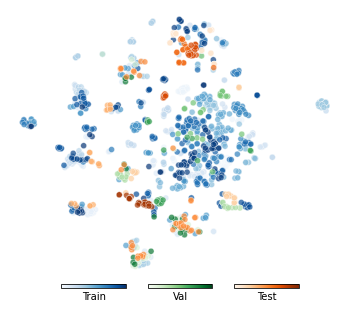

In [25]:
# mix up
X_PCA = PCA(n_components=400).fit_transform(X)
d_X = TSNE(perplexity=30, n_iter=5000, learning_rate=20).fit_transform(X_PCA)
d_train = d_X[:740]
d_val = d_X[740:840]
d_test = d_X[840:]

scatter_plot(d_train, Y_train, d_val, Y_val, d_test, Y_test, "iwildcam_mix_30.png")

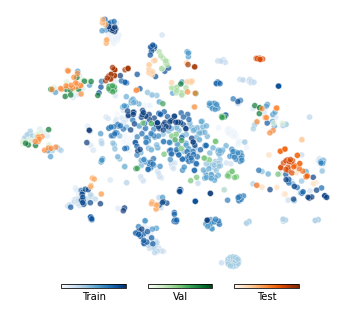

In [26]:
# mix up
X_PCA = PCA(n_components=400).fit_transform(X)
d_X = TSNE(perplexity=50, n_iter=5000, learning_rate=20).fit_transform(X_PCA)
d_train = d_X[:740]
d_val = d_X[740:840]
d_test = d_X[840:]

scatter_plot(d_train, Y_train, d_val, Y_val, d_test, Y_test, "iwildcam_mix_50.png")

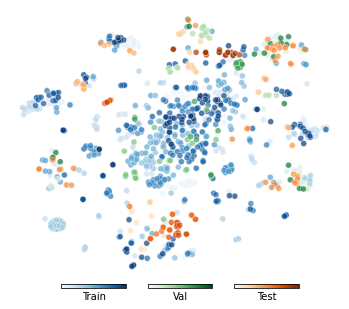

In [27]:
# mix up
X_PCA = PCA(n_components=400).fit_transform(X)
d_X = TSNE(perplexity=80, n_iter=5000, learning_rate=20).fit_transform(X_PCA)
d_train = d_X[:740]
d_val = d_X[740:840]
d_test = d_X[840:]

scatter_plot(d_train, Y_train, d_val, Y_val, d_test, Y_test, "iwildcam_mix_80.png")